In [1]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
from time import sleep
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import datetime as dt

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [13]:
def parser(browser,df):    
    
    soup = BeautifulSoup(browser.page_source)
    reviews = soup.find('div', attrs = {'class':'review_table'}).findAll('li')

    for r in reviews:
        try:
            user = r.find('span',{'data-qa':'review-name'}).text
        except:  ##if the user deleted his profile we will get an error
            user = 'DELETED USER'
        stars = r.find('span', attrs = {'class': 'star-display'})
        full_stars = len(stars.findAll('span', attrs = {'class':'star-display__filled'}))
        half_stars = len(stars.findAll('span', attrs = {'class':'star-display__half'}))
        review_text = r.find('p',attrs = {'data-qa':'review-text'}).text
        date = r.find('span',{'data-qa':'review-duration'}).text

        star_number = full_stars + half_stars*0.5

        row = [user,date,review_text,star_number]  #creating row of the dataframe
        df.loc[-1] = row
        df.index = df1.index + 1  # shifting index
        df = df1.sort_index()  # sorting by index
        
    return df   

In [15]:
options = Options()
options.add_argument("--headless") ##run the browser in background - delete 
                                   ##delete this line if you want to watch what the browser is doing
browser = webdriver.Chrome(ChromeDriverManager().install(), options=options)
url = 'https://www.rottentomatoes.com/m/star_wars_the_rise_of_skywalker/reviews?type=verified_audience&intcmp=rt-scorecard_audience-score-reviews'
browser.get(url)

df = pd.DataFrame(columns = ['user','date','review','stars']) ## creating empty dataframe
n = 0  ##number of pages 

print('Parsing through pages....\n')
while True:
    
    df1 = parser(browser,df)
    try:
        next_button = browser.find_element_by_xpath('.//button[@data-direction = "next"]')
        next_button.click()   ##go to next page
        sleep(2)
        browser.implicitly_wait(60)
        n+=1
        
    except Exception as e:
        break
        
print('Parsed through {} pages'.format(n))    
browser.close()



====== WebDriver manager ======
Current google-chrome version is 100.0.4896
Get LATEST chromedriver version for 100.0.4896 google-chrome
Driver [/home/ale/.wdm/drivers/chromedriver/linux64/100.0.4896.60/chromedriver] found in cache
<ipython-input-15-c8511481d835>:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser = webdriver.Chrome(ChromeDriverManager().install(), options=options)


Parsing through pages....



<ipython-input-15-c8511481d835>:16: DeprecationWarning: find_element_by_xpath is deprecated. Please use find_element(by=By.XPATH, value=xpath) instead
  next_button = browser.find_element_by_xpath('.//button[@data-direction = "next"]')


Parsed through 1864 pages


In [236]:
df = pd.read_csv('reviews.csv', index_col= [0])
df.drop_duplicates(inplace = True)  ## there are a few duplicates in the dataframe

In [237]:
df['date'] = pd.to_datetime(df["date"])  ## converting the 'date' column into datetime
df.head()

,user,date,review,stars
0,Lachelle C,2019-12-24,Like able characters and action packed. Whats ...,5.0
1,Angie,2019-12-24,1st Star Wars movie I’ve seen. Story was goo...,3.0
2,Dwayne,2019-12-24,Story was horrible. The director J.J. Abrams d...,1.0
3,Chris,2019-12-24,The movie didn’t have a Star Wars vibe. The mo...,2.5
4,Maria,2019-12-24,Ben solo and Rey should’ve ended up together :(,4.5


In [238]:
df['conv_stars'] = ['BAD' if value <=2 else 'NEUTRAL' if value <=3.5 else 'GOOD' for value in df['stars']]

Converted the number of stars into 3 categories: good reviews (4-5 stars), neutral reviews (2.5-3.5 stars), bad reviews (0.5-2 stars)

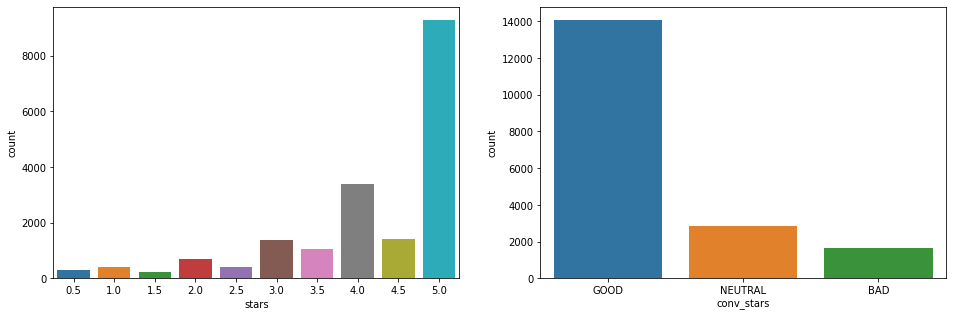

In [239]:
fig, axs = plt.subplots(ncols=2, figsize=(16,5))
sns.countplot(x='stars', data = df, ax=axs[0])
sns.countplot(x = 'conv_stars',data = df, ax=axs[1])
plt.show()

As we can see from this graph, it seems like most people rated highly the movie. Most users rated the movie 5 stars out of 5.

In [235]:
df = pd.read_csv('reviews.csv', index_col= [0])
df.drop_duplicates(inplace = True)  ## there are a few duplicates in the dataframe

## SENTIMENT ANALYSIS WITH VADER

In [240]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ale/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [241]:
sent = SentimentIntensityAnalyzer()   ##using the VADER compound method to get a more direct result
df['sentiment_score'] = [round(sent.polarity_scores(i)['compound'], 2) for i in df['review']] 

In [242]:
df['conv_sentiment'] = ['BAD' if value <=-0.33 else 'GOOD' if value >= 0.33 else 'NEUTRAL' for value in df['sentiment_score'] ]

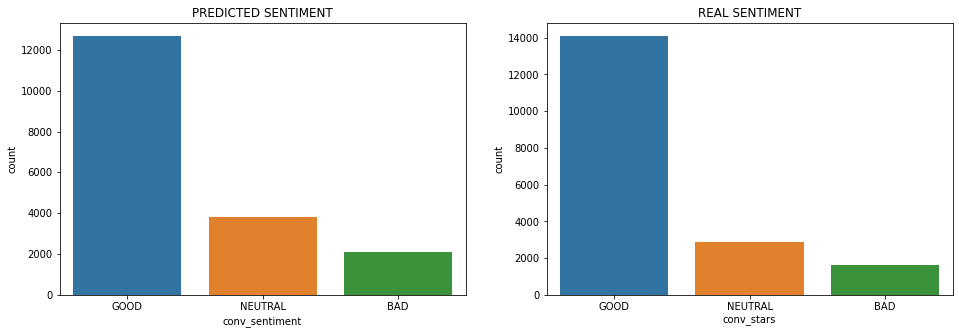

In [298]:
fig, axs = plt.subplots(ncols=2, figsize=(16,5))
sns.countplot(x='conv_sentiment', data = df, ax=axs[0],order = ['GOOD','NEUTRAL','BAD']).set(title = 'PREDICTED SENTIMENT')
sns.countplot(x = 'conv_stars',data = df, ax=axs[1]).set(title = 'REAL SENTIMENT')
plt.show()

As we can see from this countplot, it looks like VADER had a high rate of correct predictions. 
The graph, however, shows that VADER tends to overestimate NEUTRAL and BAD reviews and underestimate GOOD ones

In [262]:
correct_predictions = df.loc[(df['conv_stars'] == df['conv_sentiment'])].shape[0]
total_rows = df.shape[0] 

print('SUCCESSFUL PREDICTION RATE --- > {}'.format(correct_predictions/total_rows))

SUCCESSFUL PREDICTION RATE --- > 0.6776344086021505


VADER had a successful prediction rate of almost 70%!